# Lofi Generator

## Description

The goal is to generate LoFI that continues a song. In other words, given a LoFI sample, we create a potential continuation of that sample. We'll be generating raw audio.

## Setup

In this section, all we do is import the libraries we will be using and define some constants.

In [1]:
# torch
import torch
import torch.nn as nn
import torchaudio

# other utilities
import numpy as np
import os
import random
import math
import librosa

# display
import IPython.display as display
from IPython.display import Audio
import matplotlib.pyplot as plt


In [54]:
DATA_PREFIX = "d:/LofiData/"
SECONDS = 2

OG_SR = 48000
NEW_SR = 16000

BATCH_SIZE = 512

N_FFT=400
WINDOW_SIZE=400
HOP_LENGTH = 300

EMBEDDING_DIM = (N_FFT//2+1)*2

## See what a spectrogram looks like

In [24]:
song, sr = torchaudio.load(DATA_PREFIX+"lofi-part13.wav")

In [25]:
inps, outs = [], []
for i in range(100):
    inps.append(song[0, i*sr:(i+1)*sr].numpy())
inps = np.array(inps)
inps = torch.tensor(inps)

In [55]:
spectrogrammer = torchaudio.transforms.Spectrogram(power=None, n_fft=N_FFT, win_length=WINDOW_SIZE, hop_length=HOP_LENGTH)
spectrograms = spectrogrammer(inps)

In [44]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(np.abs(spec)**2), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

torch.Size([100, 201, 161])


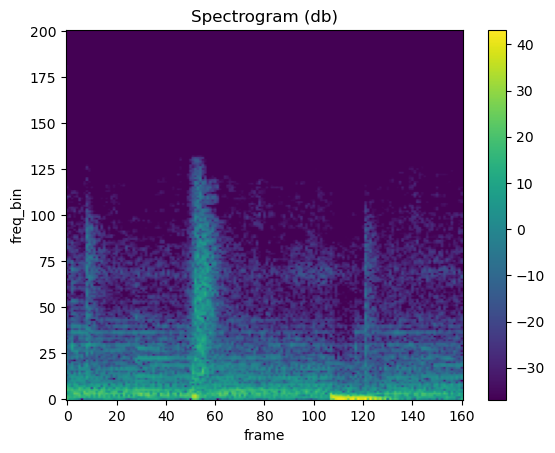

In [45]:
print(spectrograms.shape)
plot_spectrogram(spectrograms[0])

I didn't want to just concatenate the tensors because of the fact that there's an association between the reals and the imaginaries

In [46]:
temp = torch.zeros(spectrograms.shape[0], spectrograms.shape[1]*2, spectrograms.shape[2])
temp[:, 0::2] = spectrograms.real
temp[:, 1::2] = spectrograms.imag

temp.shape

torch.Size([100, 402, 161])

As we can see below, now they are right next to each other!!

In [47]:
spectrograms[0, 0:2, 0]

tensor([-9.2107+0.0000e+00j,  9.5249+4.7684e-07j])

In [48]:
temp[0, 0:4, 0]

tensor([-9.2107e+00,  0.0000e+00,  9.5249e+00,  4.7684e-07])

In [56]:
un_spectrogrammer = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, win_length=WINDOW_SIZE, hop_length=HOP_LENGTH)
recomposed_song = un_spectrogrammer(spectrograms)

In [57]:
display.Audio(recomposed_song[5], rate=sr)

## Input Pipeline

In [59]:
def transform_idx(idx):
    return idx * NEW_SR * SECONDS


def untransform_idx(idx):
    return idx // NEW_SR // SECONDS


def prepare_inputs():
    all_files = os.listdir(DATA_PREFIX)

    cur_list = all_files.copy()
    resampler = torchaudio.transforms.Resample(OG_SR, NEW_SR)
    spectrogrammer = torchaudio.transforms.Spectrogram(power=None, n_fft=N_FFT, win_length=WINDOW_SIZE, hop_length=HOP_LENGTH)

    cur_idx = 0
    while len(cur_list) != 0:
        # get new song if necessary
        if cur_idx == 0:
            song_name = cur_list.pop(random.randrange(0, len(cur_list)))

            # resample
            song, _ = torchaudio.load(DATA_PREFIX + song_name)
            song = resampler(song)
            song = song[0].numpy()

        # take BATCH_SIZE pairs
        inputs = []
        outputs = []
        for i in range(min(untransform_idx(len(song)) - 2 - cur_idx, BATCH_SIZE)):
            i += cur_idx
            inputs.append(song[transform_idx(i) : transform_idx(i + 1)])
            outputs.append(song[transform_idx(i + 1) : transform_idx(i + 2)])

        # if we used up our current song, set cur_idx to 0. Else, set it to the
        # idx we ended up on
        if i == untransform_idx(len(song)) - 3:
            cur_idx = 0
        else:
            cur_idx = i

        # convert to np array and then to tensors
        inputs = torch.tensor(np.array(inputs))
        outputs = torch.tensor(np.array(outputs))

        inputs = spectrogrammer(inputs)
        outputs = spectrogrammer(outputs)

        # convert to regular floats instead of complex floats
        temp_inputs = torch.zeros(inputs.shape[0], inputs.shape[1]*2, inputs.shape[2])
        temp_outputs = torch.zeros(outputs.shape[0], outputs.shape[1]*2, outputs.shape[2])
        temp_inputs[:, 0::2] = inputs.real
        temp_inputs[:, 1::2] = inputs.imag
        temp_outputs[:, 0::2] = outputs.real
        temp_outputs[:, 1::2] = outputs.imag


        # cleanup
        del inputs
        del outputs

        yield temp_inputs, temp_outputs


In [60]:
for inputs, outputs in prepare_inputs():
    print(inputs.shape)
    break

torch.Size([512, 402, 107])


## Model

In [13]:
"""class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)

        # Info
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(
            -1, 1
        )  # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(
            torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model
        )  # 1000^(2i/dim_model)

        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)

        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(
            token_embedding + self.pos_encoding[: token_embedding.size(0), :]
        )"""

"""class PositionalEncodingAudio(nn.Module):
    def __init__(self, dropout_p, len):
        super().__init__()
        # max_len determines how far the position can have an effect on a token (window)

        # Info
        self.dropout = nn.Dropout(dropout_p)

        # Encoding - From formula
        pos_encoding = torch.zeros(len)
        positions_list = torch.arange(0, len, dtype=torch.float)  # 0, 1, 2, 3, 4, 5, ...
        division_term = torch.exp(
            torch.arange(0, len, 1).float() * (-math.log(10000.0)) / len
        )  # 1000^(i/dim_model)

        # PE(pos, 2i) = sin(pos/1000^(i/dim_model))
        pos_encoding[:] = torch.sin(positions_list * division_term)

        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.view(1, -1, 1).to("cuda")
        self.register_buffer("pos_encoding", pos_encoding)

    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        token_embedding = token_embedding.view(token_embedding.size(0), token_embedding.size(1), 1)
        return self.dropout(
            torch.concat([token_embedding, self.pos_encoding.expand(token_embedding.size(0), -1, -1)], dim=-1)
        )"""
        

class LofiAttention(nn.Module):
    def __init__(self) -> None:
        super(LofiAttention, self).__init__()

        encoder_layers = nn.TransformerEncoderLayer(EMBEDDING_DIM, 3, 512, activation='relu')
        self.encoding = nn.TransformerEncoder(encoder_layers, 5)
        self.out = nn.Sequential(nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM), nn.GELU(), nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM))

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Args:
            src: Tensor, shape [batch_size, (num_fft//2+1)*2, frames]
        Output:
            out: Tensor, shape [batch_size, (num_fft//2+1)*2, frames]
        """

        # from  [batch_size, num_fft//2+1, frames] to [frames, batch_size, num_fft//2+1]
        src = src.permute(2, 0, 1)

        # pass through transformer
        out = self.encoding(src)

        # pass through out linear layer
        out = self.out(out)

        # reshape back into [batch_size, num_fft//2+1, frames]
        out = out.permute(1, 2, 0)
        return out



In [14]:
model = LofiAttention()

In [15]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
total_params = sum([np.prod(p.size()) for p in model_parameters])
total_params


5634982

In [16]:
# for inputs, outputs in prepare_inputs():
#     model.to("cuda")
#     inputs = inputs.to("cuda")
#     out = model(inputs)
#     print(out.shape)
#     break


## Loss, Optimizers

In [17]:
loss = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda step: max(7e-6, 1e-4 - 5e-6*step))

## Train

In [18]:
def train(model:LofiAttention, loss_fn, optimizer, device, epochs=1):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        batch = 0
        for X, y in prepare_inputs():
            X, y = X.to(device), y.to(device)

            pred = model(X)

            # calculate loss
            loss = loss_fn(pred, y).sum()

            # Backpropogate
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            scheduler.step()

            loss = loss.item()
            print(f"loss: {loss:>7f} -- average loss: {loss/len(y):>7f} -- [batch number {batch+1}, epoch {epoch+1}/{epochs}]")

            batch += 1


In [19]:
train(model, loss, optim, "cuda", 6)


loss: 1.595492 -- average loss: 0.003116 -- [batch number 1, epoch 1/6]
loss: 3.080954 -- average loss: 0.006017 -- [batch number 2, epoch 1/6]
loss: 2.196114 -- average loss: 0.004289 -- [batch number 3, epoch 1/6]
loss: 1.709507 -- average loss: 0.003339 -- [batch number 4, epoch 1/6]
loss: 1.768000 -- average loss: 0.005649 -- [batch number 5, epoch 1/6]
loss: 1.344136 -- average loss: 0.002625 -- [batch number 6, epoch 1/6]
loss: 1.517548 -- average loss: 0.002964 -- [batch number 7, epoch 1/6]
loss: 2.243526 -- average loss: 0.004382 -- [batch number 8, epoch 1/6]
loss: 0.578546 -- average loss: 0.018663 -- [batch number 9, epoch 1/6]
loss: 1.337764 -- average loss: 0.002613 -- [batch number 10, epoch 1/6]
loss: 1.519918 -- average loss: 0.002969 -- [batch number 11, epoch 1/6]
loss: 2.243876 -- average loss: 0.004383 -- [batch number 12, epoch 1/6]
loss: 1.705442 -- average loss: 0.003921 -- [batch number 13, epoch 1/6]
loss: 2.189862 -- average loss: 0.004277 -- [batch number 14

KeyboardInterrupt: 

In [20]:
def produce_outputs():
    model.to("cuda")
    model.eval()
    with torch.no_grad():
        for inputs, _ in prepare_inputs():
            inputs = inputs.to("cuda")
            
            outputs = model(inputs)
            break

    # move to cpu
    outputs = outputs.to("cpu")

    # convert to complex
    inverse_spectrogrammer = torchaudio.transforms.InverseSpectrogram()
    complex_outputs = torch.zeros(outputs.size(0), outputs.size(1)//2, outputs.size(2)).type(torch.complex64)
    complex_outputs.real = outputs[:, 0::2]
    complex_outputs.imag = outputs[:, 1::2]
    outputs = inverse_spectrogrammer(complex_outputs)

    # take 8 random samples and plot them
    idx = random.randrange(0, len(outputs) - 8)
    outputs = outputs[idx : idx + 8]

    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)

    for i in range(len(outputs)):
        axs[i // 4, i % 4].plot(np.arange(len(outputs[i])), outputs[i])
        display.display(Audio(outputs[i], rate=NEW_SR))

    plt.show()


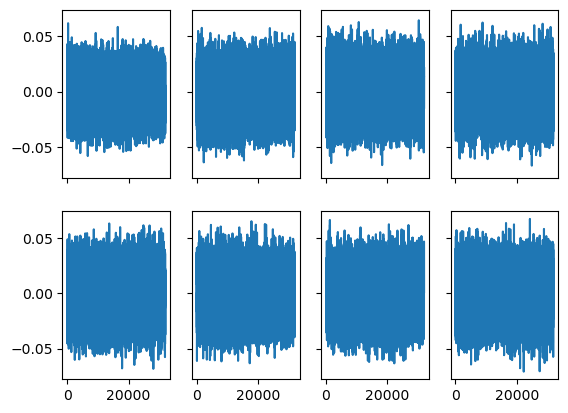

In [21]:
produce_outputs()
